# Going Deeper Convolutions in Keras
> Convolutional neural networks gain a lot of power when they are constructed with multiple layers (deep networks). In this chapter, you will learn how to stack multiple convolutional layers into a deep network. You will also learn how to keep track of the number of parameters, as the network grows, and how to control this number. This is the Summary of lecture "Image Processing with Keras in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Vision, Deep_Learning]
- image: images/brick_maxpool.png

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Going Deeper

### Creating a deep learning network
A deep convolutional neural network is a network that has more than one layer. Each layer in a deep network receives its input from the preceding layer, with the very first layer receiving its input from the images used as training or test data.

Here, you will create a network that has two convolutional layers.



In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

img_rows, img_cols = 28, 28

model = Sequential()

# Add a convolutional layer (15 units)
model.add(Conv2D(15, kernel_size=2, input_shape=(img_rows, img_cols, 1), activation='relu'))

# Add another convolutional layer (5 units)
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 15)        75        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 5)         305       
_________________________________________________________________
flatten (Flatten)            (None, 3380)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 10143     
Total params: 10,523
Trainable params: 10,523
Non-trainable params: 0
_________________________________________________________________


### Train a deep CNN to classify clothing images
Training a deep learning model is very similar to training a single layer network. Once the model is constructed (as you have done in the previous exercise), the model needs to be compiled with the right set of parameters. Then, the model is fit by providing it with training data, as well as training labels. After training is done, the model can be evaluated on test data.

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = train_data[(train_labels >= 0) & (train_labels < 3)][0:50].reshape(-1, 28, 28, 1)
train_labels = train_labels[(train_labels >= 0) & (train_labels < 3)][0:50]
train_labels = pd.get_dummies(train_labels).to_numpy()

test_data = test_data[(test_labels >= 0) & (test_labels < 3)][0:10].reshape(-1, 28, 28, 1)
test_labels = test_labels[(test_labels >= 0) & (test_labels < 3)][0:10]
test_labels = pd.get_dummies(test_labels).to_numpy()

In [4]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to training data
model.fit(train_data, train_labels, validation_split=0.2, epochs=3, batch_size=10)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/3
4/4 [==============================] - 0s 34ms/step - loss: 22.1126 - accuracy: 0.4250 - val_loss: 0.7967 - val_accuracy: 0.9000
Epoch 2/3
4/4 [==============================] - 0s 6ms/step - loss: 3.2581 - accuracy: 0.8750 - val_loss: 4.5468 - val_accuracy: 0.8000
Epoch 3/3
1/1 [==============================] - 0s 616us/step - loss: 0.1385 - accuracy: 0.9000


[0.138534277677536, 0.8999999761581421]

## How many parameters?

### How many parameters in a CNN?
We need to know how many parameters a CNN has, so we can adjust the model architecture, to reduce this number or shift parameters from one part of the network to another. How many parameters would a network have if its inputs are images with 28-by-28 pixels, there is one convolutional layer with 10 units kernels of 3-by-3 pixels, using zero padding (input has the same size as the output), and one densely connected layer with 2 units?



In [5]:
10 * (3 * 3) + 10 + 784 * 10 * 2 + 2

15782

### How many parameters in a deep CNN?
In this exercise, you will use Keras to calculate the total number of parameters along with the number of parameters in each layer of the network.

In [6]:
# CNN model
model = Sequential()
model.add(Conv2D(10, kernel_size=2, activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(10, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 27, 27, 10)        50        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 10)        410       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 20283     
Total params: 20,743
Trainable params: 20,743
Non-trainable params: 0
_________________________________________________________________


## Pooling operations


### Write your own pooling operation
As we have seen before, CNNs can have a lot of parameters. Pooling layers are often added between the convolutional layers of a neural network to summarize their outputs in a condensed manner, and reduce the number of parameters in the next layer in the network. This can help us if we want to train the network more rapidly, or if we don't have enough data to learn a very large number of parameters.

A pooling layer can be described as a particular kind of convolution. For every window in the input it finds the maximal pixel value and passes only this pixel through. In this exercise, you will write your own max pooling operation, based on the code that you previously used to write a two-dimensional convolution operation.

In [7]:
from skimage import transform

im = pd.read_csv('./dataset/brick_bw.csv')
imt = transform.resize(im, (128, 128))
print(imt.shape)

(128, 128)


In [8]:
# Result placeholder
result = np.zeros((imt.shape[0] // 2, imt.shape[1] // 2))

# Pooling operation
for ii in range(result.shape[0]):
    for jj in range(result.shape[1]):
        result[ii, jj] = np.max(imt[ii * 2:ii * 2 + 2, jj * 2:jj * 2 + 2])

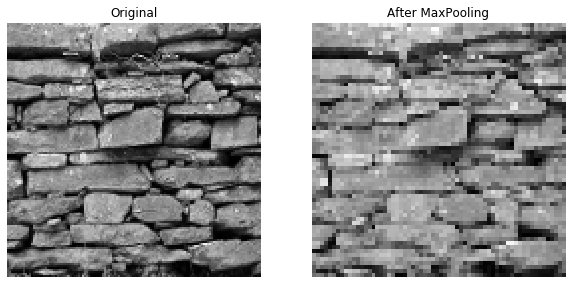

In [10]:
def plot_comparison(img_original, img_filtered, img_title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8))
    ax1.imshow(img_original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(img_filtered, cmap=plt.cm.gray)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

plot_comparison(imt, result, 'After MaxPooling')

### Keras pooling layers
Keras implements a pooling operation as a layer that can be added to CNNs between other layers. In this exercise, you will construct a convolutional neural network similar to the one you have constructed before:

**Convolution => Convolution => Flatten => Dense**

However, you will also add a pooling layer. The architecture will add a single max-pooling layer between the convolutional layer and the dense layer with a pooling of 2x2:

**Convolution => Max pooling => Convolution => Flatten => Dense**

In [11]:
from tensorflow.keras.layers import MaxPool2D

model = Sequential()

# Add a convolutional layer
model.add(Conv2D(15, kernel_size=2, activation='relu', input_shape=(img_rows, img_cols, 1)))

# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 15)        75        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 5)         305       
_________________________________________________________________
flatten_2 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2163      
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit to training data
model.fit(train_data, train_labels, epochs=3, validation_split=0.2, batch_size=10);

# Evaluate on test data
model.evaluate(test_data, test_labels, batch_size=10);

Epoch 1/3
4/4 [==============================] - 0s 21ms/step - loss: 15.4574 - accuracy: 0.5000 - val_loss: 8.1313 - val_accuracy: 0.3000
Epoch 2/3
4/4 [==============================] - 0s 5ms/step - loss: 5.8975 - accuracy: 0.5750 - val_loss: 5.9405 - val_accuracy: 0.4000
Epoch 3/3
1/1 [==============================] - 0s 545us/step - loss: 4.1620 - accuracy: 0.6000
